In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd 
import cv2
import json
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet121
import efficientnet.tfkeras as efn
print('tensorflow version:', tf.__version__)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      '| device num:', os.environ['CUDA_VISIBLE_DEVICES'])
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'physical GPUs,', len(logical_gpus), 'logical GPUs')
    except RuntimeError as e:
        print(e)

tensorflow version: 1.14.0
available GPU devices: 1 | device num: 0
1 physical GPUs, 1 logical GPUs


In [2]:
DATA_PATH = './data'
MODELS_PATH = './models'
IMG_SIZE = 112
SEQ_LEN = 8
BATCH_SIZE = 16
MDL_VERSION = 'v2'
TIFF = -1
RESIZE = None
SEED = 80
#169 8 6 1 2 => 0.7317
print('96x96x16 size:', 96 * 96 * 16)
print('96x96x25 size:', 96 * 96 * 25)
print('128x128x12 size:', 128 * 128 * 12)
print('154x154x10 size:', 154 * 154 * 10)
print('current size:', IMG_SIZE * IMG_SIZE * SEQ_LEN)

96x96x16 size: 147456
96x96x25 size: 230400
128x128x12 size: 196608
154x154x10 size: 237160
current size: 100352


In [3]:
train = pd.read_csv('{}/train.csv'.format(DATA_PATH))
print('train: ', train.shape, '| unique ids:', sum(train['isup_grade'].value_counts()))
train.data_provider.value_counts()

train:  (10616, 4) | unique ids: 10616


karolinska    5456
radboud       5160
Name: data_provider, dtype: int64

In [4]:
def enhance_image(image, contrast=1, brightness=15):
    img_enhanced = cv2.addWeighted(image, contrast, image, 0, brightness)
    return img_enhanced
def get_axis_max_min(array, axis=0):
    one_axis = list((array != 255).sum(axis=tuple([x for x in (0, 1, 2) if x != axis])))
    axis_min = next((i for i, x in enumerate(one_axis) if x), 0)
    axis_max = len(one_axis) - next((i for i, x in enumerate(one_axis[::-1]) if x), 0)
    return axis_min, axis_max
def compute_statistics(image):
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height
    num_white_pixels = 0
    summed_matrix = np.sum(image, axis=-1)
    num_white_pixels = np.count_nonzero(summed_matrix == (3 * np.max(image)))
    ratio_white_pixels = num_white_pixels / num_pixels
    return ratio_white_pixels
def select_k_best_regions(regions, k):
    k_best_regions = sorted(regions, key=lambda tup: tup[2])[:k]
    return k_best_regions
def get_k_best_regions(coordinates, image, window_size):
    regions = []
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions.append(image[x : x+window_size, y : y+window_size, :])
    return regions

In [5]:
class DataGenPanda(Sequence):
    def __init__(self, imgs_path, df, batch_size=32, 
                 mode='fit', shuffle=False, aug=None,
                 tiff=-1, resize=None,
                 seq_len=12, img_size=128, n_classes=6):
        self.imgs_path = imgs_path
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.tiff = tiff
        self.resize = resize
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.n_classes = n_classes
        self.side = int(seq_len ** .5)
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.seq_len, self.img_size, self.img_size, 3), dtype=np.float32)
        imgs_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['image_id'].values
        for i, img_name in enumerate(imgs_batch):
            img_path = '{}/{}.tiff'.format(self.imgs_path, img_name)
            img_patches = self.get_patches(img_path)
            X[i, ] = img_patches
        if self.mode == 'fit':
            y = np.zeros((self.batch_size, self.n_classes), dtype=np.float32)
            lbls_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')
    def get_patches_(self, img_path):
        num_patches = self.seq_len
        p_size = self.img_size
        img = skimage.io.MultiImage(img_path)[self.tiff]
        #img = enhance_image(img)
        if self.resize:
            img = cv2.resize(img, (int(img.shape[1] / self.resize), int(img.shape[0] / self.resize)))
        a0min, a0max = get_axis_max_min(img, axis=0)
        a1min, a1max = get_axis_max_min(img, axis=1)
        img = img[a0min:a0max, a1min:a1max, :].astype(np.float32) / 255
        if self.aug:
            img = self.aug(image=img)['image']
        regions_container = []
        i = 0
        stride = int(p_size / 2)
        while p_size + stride * i <= img.shape[1]:
            j = 0
            while p_size + stride * j <= img.shape[0]:            
                x_top_left_pixel = j * stride
                y_top_left_pixel = i * stride
                patch = img[
                    x_top_left_pixel : x_top_left_pixel + p_size,
                    y_top_left_pixel : y_top_left_pixel + p_size,
                    :
                ]
                ratio_white_pixels = compute_statistics(patch)
                region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels)
                regions_container.append(region_tuple)
                j += 1
            i += 1
        k_best_region_coordinates = select_k_best_regions(regions_container, num_patches)
        k_best_regions = get_k_best_regions(k_best_region_coordinates, img, p_size)
        return np.array(k_best_regions)
    def get_patches(self, img_path):
        num_patches = self.seq_len
        p_size = self.img_size
        img = skimage.io.MultiImage(img_path)[self.tiff]
        #img = enhance_image(img)
        if self.resize:
            img = cv2.resize(img, (int(img.shape[1] / self.resize), int(img.shape[0] / self.resize)))
        a0min, a0max = get_axis_max_min(img, axis=0)
        a1min, a1max = get_axis_max_min(img, axis=1)
        img = img[a0min:a0max, a1min:a1max, :].astype(np.float32) / 255
        if self.aug:
            img = self.aug(image=img)['image']
        pad0, pad1 = (p_size - img.shape[0] % p_size) % p_size, (p_size - img.shape[1] % p_size) % p_size
        img = np.pad(
            img,
            [
                [pad0 // 2, pad0 - pad0 // 2], 
                [pad1 // 2, pad1 - pad1 // 2], 
                [0, 0]
            ],
            constant_values=1
        )
        img = img.reshape(img.shape[0] // p_size, p_size, img.shape[1] // p_size, p_size, 3)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, p_size, p_size, 3)
        if len(img) < num_patches:
            img = np.pad(
                img, 
                [
                    [0, num_patches - len(img)],
                    [0, 0],
                    [0, 0],
                    [0, 0]
                ],
                constant_values=1
            )
        idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_patches]
        return np.array(img[idxs])

test X:  (16, 8, 112, 112, 3)
test y:  (16, 6)


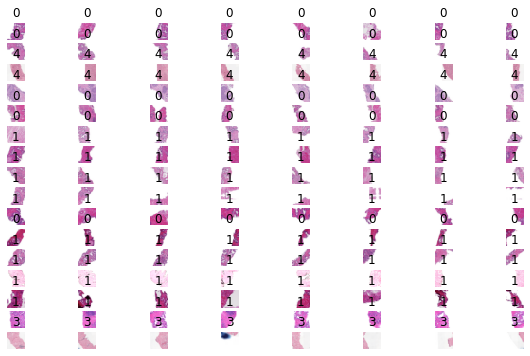

CPU times: user 3.02 s, sys: 92 ms, total: 3.12 s
Wall time: 2.77 s


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [6]:
%%time
aug = albu.Compose(
    [
        albu.OneOf(
            [
                albu.RandomBrightness(limit=.15), 
                albu.RandomContrast(limit=.3), 
                albu.RandomGamma()
            ], 
            p=.25
        ),
        albu.HorizontalFlip(p=.25),
        albu.VerticalFlip(p=.25),
        albu.ShiftScaleRotate(shift_limit=.1, scale_limit=.1, rotate_limit=20, p=.25)
    ]
)
train_datagen = DataGenPanda(
        imgs_path='{}/train_images'.format(DATA_PATH), 
        df=train, 
        batch_size=BATCH_SIZE,
        mode='fit', 
        shuffle=True, 
        aug=aug, 
        tiff=TIFF,
        resize=RESIZE,
        seq_len=SEQ_LEN, 
        img_size=IMG_SIZE, 
        n_classes=6
    )
Xt, yt = train_datagen.__getitem__(0)
print('test X: ', Xt.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(10, 6), nrows=BATCH_SIZE, ncols=SEQ_LEN)
for j in range(BATCH_SIZE):
    for i in range(SEQ_LEN):
        axes[j, i].imshow(Xt[j][i])
        axes[j, i].axis('off')
        axes[j, i].set_title(np.argmax(yt[j, ]))
plt.show()
yt

In [7]:
def get_train_val(X_train, X_val, aug):
    train_datagen = DataGenPanda(
        imgs_path='{}/train_images'.format(DATA_PATH), 
        df=X_train, 
        batch_size=BATCH_SIZE,
        mode='fit', 
        shuffle=True, 
        aug=aug, 
        tiff=TIFF,
        resize=RESIZE,
        seq_len=SEQ_LEN, 
        img_size=IMG_SIZE, 
        n_classes=6
    )
    val_datagen = DataGenPanda(
        imgs_path='{}/train_images'.format(DATA_PATH), 
        df=X_val, 
        batch_size=BATCH_SIZE,
        mode='fit', 
        shuffle=False, 
        aug=None,
        tiff=TIFF,
        resize=RESIZE,
        seq_len=SEQ_LEN, 
        img_size=IMG_SIZE, 
        n_classes=6
    )
    return train_datagen, val_datagen

In [8]:
def qw_kappa_score(y_true, y_pred): 
    y_true=tf.math.argmax(y_true, axis=1)
    y_pred=tf.math.argmax(y_pred, axis=1)
    def sklearn_qwk(y_true, y_pred) -> np.float64:
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return tf.compat.v1.py_func(sklearn_qwk, (y_true, y_pred), tf.double)
def get_model(n_classes=6):
    bottleneck = efn.EfficientNetB1(weights='imagenet', include_top=False, pooling='avg')
    #bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
    #bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers.output)
    model = Sequential()
    model.add(TimeDistributed(bottleneck, input_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(LSTM(256))
    #model.add(TimeDistributed(BatchNormalization()))
    #model.add(TimeDistributed(GlobalMaxPooling2D()))
    #model.add(Flatten())
    #model.add(GlobalMaxPooling3D())
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(128, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=1e-3),
        metrics=['categorical_accuracy', qw_kappa_score]
    )
    return model

In [9]:
model = get_model(n_classes=6)
model.summary()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 8, 1280)           6575232   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 1280

In [10]:
%%time
EPOCHS = 100
skf = StratifiedKFold(n_splits=4, random_state=SEED, shuffle=False)
for i_fold, (train_idxs, val_idxs) in enumerate(skf.split(train, train['isup_grade'])):
    print('=' * (50 + len(' FOLD X ')))
    print('=' * 25, 'FOLD', i_fold, '=' * 25)
    X_train, X_val = train.loc[train_idxs, :], train.loc[val_idxs, :]
    lbl_value_counts = X_train['isup_grade'].value_counts()
    class_weights = {i: max(lbl_value_counts) / v for i, v in lbl_value_counts.items()}
    print('class weights:', class_weights)
    train_datagen, val_datagen = get_train_val(X_train, X_val, aug)
    model = get_model(n_classes=6)
    model_file = '{}/model_{}_fold_{}.h5'.format(MODELS_PATH, MDL_VERSION, i_fold)
    if False:
        model = load_model(model_file)
        print('model loaded')
    else:
        print('train from scratch')
    earlystopper = EarlyStopping(
        monitor='val_qw_kappa_score', 
        patience=10, 
        verbose=1, 
        mode='max'
    )
    modelsaver = ModelCheckpoint(
        model_file, 
        monitor='val_qw_kappa_score', 
        verbose=1, 
        save_best_only=True, 
        mode='max'
    )
    lrreducer = ReduceLROnPlateau(
        monitor='val_qw_kappa_score', 
        factor=.1, 
        patience=5,
        verbose=1, 
        min_lr=1e-7
    )
    history = model.fit_generator(
        train_datagen, 
        validation_data=val_datagen,
        class_weight=class_weights,
        callbacks=[earlystopper, modelsaver, lrreducer], 
        epochs=EPOCHS, 
        verbose=1
    )
    history_file = '{}/history_{}_fold_{}.txt'.format(MODELS_PATH, MDL_VERSION, i_fold)
    dict_to_save = {}
    for k, v in history.history.items():
        dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
    with open(history_file, 'w') as file:
        json.dump(dict_to_save, file)
    del X_train, X_val, train_datagen, val_datagen, model
    gc.collect()

========================= FOLD 0 =========================
class weights: {0: 1.0, 1: 1.0845, 2: 2.1517857142857144, 4: 2.3173076923076925, 3: 2.329752953813104, 5: 2.3627450980392157}


train from scratch
Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
496/497 [============================>.] - ETA: 0s - loss: 3.1450 - categorical_accuracy: 0.2785 - qw_kappa_score: 0.3347
Epoch 00001: val_qw_kappa_score improved from -inf to 0.42340, saving model to ./models/model_v2_fold_0.h5
497/497 [==============================] - 472s 951ms/step - loss: 3.1448 - categorical_accuracy: 0.2785 - qw_kappa_score: 0.3348 - val_loss: 1.9420 - val_categorical_accuracy: 0.2561 - val_qw_kappa_score: 0.4234
Epoch 2/100
496/497 [============================>.] - ETA: 0s - loss: 2.6741 - categorical_accuracy: 0.3514 - qw_kappa_score: 0.4727
Epoch 00002: val_qw_kappa_score improved from 0.42340 to 0.60403, saving model to ./models/model_v2_fold_0.h5
497/497 [==============================] - 459s 924ms/step - loss: 2.6749 - categorical_accuracy: 0.3516 - qw_kappa_score: 0.4728 - val_loss: 1.3359 - val_categorical_accuracy: 0.4659 - val

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[128,1280,4,4] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node time_distributed_1/top_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_2/categorical_accuracy/Identity/_11751]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[128,1280,4,4] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node time_distributed_1/top_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
history_file = '{}/history_{}.txt'.format(MODELS_PATH, MDL_VERSION)
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['categorical_accuracy'][:ep_max], label='cat acc')
plt.plot(history.history['val_categorical_accuracy'][:ep_max], label='val cat acc')
plt.legend()
plt.show()
plt.plot(history.history['qw_kappa_score'][:ep_max], label='qwk')
plt.plot(history.history['val_qw_kappa_score'][:ep_max], label='val qwk')
plt.legend()
plt.show()

In [ ]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
model = load_model(model_file, custom_objects={'qw_kappa_score': qw_kappa_score})
print('model loaded:', model_file)

In [ ]:
%%time
X_score = X_val.copy()
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_score, 
    batch_size=1,
    mode='predict', 
    shuffle=False, 
    aug=None,
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
preds = model.predict_generator(val_datagen)

In [ ]:
y_true = X_score['isup_grade'].values
y_pred = np.argmax(preds, axis=1)
print('quadratic cappa score:', cohen_kappa_score(y_true, y_pred, weights='quadratic'))
print('confusion matrix:\n', confusion_matrix(y_true, y_pred))